In [1]:
import scipy
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import scipy.optimize as spo
from scipy.optimize import minimize
import scipy.constants as const
from scipy.spatial.transform import Rotation as R
import copy
import py3Dmol as p3d
import ipywidgets

## Constants

In [2]:
# Valor de bohr en metros
bohr_factor = const.value('Bohr radius')
# Factor de conversión de angstrom a bohr
angstrom_to_bohr = const.angstrom / bohr_factor # 1.8897261246257702
hartree_to_kcal = 627.509
kJ_to_kcal = 1 / 4.184
kcal_to_kJ = 4.184
hartree_to_kJ = 2625.5
bohr_6_to_angstrom_6 = 0.0219586

### important information - 

- The xyz file needs to specify the type of atom in the same way as the buckingham forcefield does.

- The charges vector needs to have the same arrangement of the xyz file, atom 1 in xyz file is [0] and   final atom in the xyz file needs to be the [-1] in the vector.

- 

# Classes for molecules, dimers and energy calculation.

In [267]:
class MolBuckingham:
    def __init__(self, file_xyz, vector_charges):

        # check if the vector charges and the file have the same length once the two vectors are created 

        '''This class is used to define the molecule,
            The parameters A, B and C, from buckingham potential,
            and the methods needed to change it or copy the molecule.
            
            ------------------------------------------------------
            specifications: 

            the file has to be a normal xyz file with the atoms coords
            starting in the third line, first is number of atoms and second is blank

            for this specific scrip the molecules have to be labeled as in the
            buckingham potential nomenclature. ex. C -- >  C(1), C(2), C(4) etc

            
            '''
        

        # # from 18 #### original with optimization of pf6-pf6
        # buckingham_parameters = {
        # 'F': {'A': 13044.8082, 'B': 2406.77297, 'C': 1.69854449},
        # 'P': {'A': 8781.04056, 'B': 630.760768, 'C': 1.51810656},
        # 'C(4)': {'A': 978.36, 'B': 131571, 'C': 3.60},
        # 'H(4)': {'A': 0.00, 'B': 764.9, 'C': 3.56},
        # 'H(1)': {'A': 278.37, 'B': 12680, 'C': 3.56},  
        # 'N(3)': {'A': 2376.55, 'B': 191935, 'C': 3.48}
        # } # ['F', 'P', 'C(4)', 'H(4)', 'H(1)', 'N(3)'] # originals

        # pf6-pf6 optimiz from 18 [1.30448082e+04 8.78104056e+03 2.40677297e+03 6.30760768e+02
        #  1.69854449e+00 1.51810656e+00]


        buckingham_parameters = {
        'F': {'A': 1.25245814e+04, 'B': 2.64658600e+03, 'C': 1.76967562e+00},
        'P': {'A': 8.50092649e+03, 'B': 5.98129383e+02, 'C': 1.48749717e+00},
        'C(4)': {'A': 9.76618460e+02, 'B': 1.39355231e+05, 'C': 3.77124887e+00},
        'H(4)': {'A': 2.25451832e-05, 'B': 6.89049508e+02, 'C': 3.71869158e+00},
        'H(1)': {'A': 2.70782383e+02, 'B': 1.39479857e+04, 'C': 3.60050263e+00},  
        'N(3)': {'A': 2.28816383e+03, 'B': 1.73899497e+05, 'C': 3.46063789e+00}
        }



        self.buckingham_original_parameters = buckingham_parameters.copy()

        self.file_xyz = file_xyz # to store the file
        self.num_atoms = '999' # some number to initialize the atribute
        self.atom_types = [] # vector to store the atom types of the molecule
        self.coordinates = [] # vector to store the coordinaties of each atom in the molecule 
        self.charges = np.array(vector_charges) # vector to store the charge of each atom in the molecule 
        
        # --------------------------------------------
        ''' The next part is to read the xyz file and separate 
            the atom name and coordinates, but they are stored in the same order so 
            we can say that the index of two list correspond to the same atom'''
        #---------------------------------------------

        with open (self.file_xyz, 'r') as file: 
            for index, line in enumerate(file):
                if index == 0:
                    self.num_atoms = line.strip()
                elif index == 1:
                    pass
                else:
                    data = line.strip().split()
                    if len(data) == 4:
                        self.atom_types.append(data[0])
                        self.coordinates.append([float(coord) for coord in data[1:]])
                    else:
                        print('weird line')            


        self.coordinates = np.array(self.coordinates) 


        # the next vectors store the values in the same order of reading to match the order of the atoms
        self.buckingham_a = [] # vector used for store the A parameters of each molecule
        self.buckingham_b = [] # vector used for store the B parameters of each molecule
        self.buckingham_c = [] # vector used for store the C parameters of each molecule
        

        for atom in self.atom_types:
            self.buckingham_a.append(buckingham_parameters[atom]['A'])
            self.buckingham_b.append(buckingham_parameters[atom]['B'])
            self.buckingham_c.append(buckingham_parameters[atom]['C'])


        # the next two are for unique names/values
        self.order_types = []
        set_types = set()

        for type in self.atom_types:
            if type not in set_types:
                set_types.add(type)
                self.order_types.append(type)


        self.buckingham_a = np.array(self.buckingham_a)
        self.buckingham_b = np.array(self.buckingham_b).astype(float)
        self.buckingham_c = np.array(self.buckingham_c)

        print(set_types)
        print(self.order_types)

    def copy (self, point, rotation = None):

        '''
        Creates a copy of the molecule with a new position and rotation.

        Parameters:
        point (array-like): The new point to which the center of the molecule will be moved.
        rotation (array-like, optional): The Euler angles (in degrees) for the rotation
                                         around the 'xyz' axes. Default is [0, 0, 0].

        Returns:
        Molecule: A new instance of Molecule with the updated coordinates.
        '''


        if rotation is None:
            rotation = [0,0,0]

        point = np.array(point)

        euler_angles = rotation 
        r = R.from_euler('xyz', euler_angles, degrees=True)
        new_copy = copy.deepcopy(self)

        mol_center = np.mean(self.coordinates, axis=0)
        translation_vector =  point - mol_center

        new_coord  = self.coordinates + translation_vector
        rotated_points = r.apply(new_coord)

        new_copy.coordinates = rotated_points

        return new_copy
    
    def visual (self):

        data_string = self.num_atoms + '\n\n'

        if len(self.atom_types) == len(self.coordinates): 
            for i in range(len(self.atom_types)):
                name = ''
                for char in self.atom_types[i]:
                    if char == '(':
                        break
                    else:
                        name += char

                data_string += name + ' ' + ' '.join(map(str, self.coordinates[i])) + '\n'
        else:
            print(f"The number of atoms ({len(self.atom_types)}) does not correspond with the number of coordinates ({len(self.coordinates)})")

        viewer = p3d.view(width=600, height=300)
        viewer.addModel(data_string, "xyz")
        viewer.addUnitCell()
        # Configurar el estilo de visualización
        viewer.setViewStyle({"style": "outline", "width": 0.05})
        viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})
        viewer.zoomTo()
        viewer.show()



In [4]:
class Dimer:
    def __init__(self, mol1, mol2):
        
        self.mol1 = mol1
        self.mol2 = mol2

        self.dimer_buckingham_params = mol1.buckingham_original_parameters

        dimer_set  = set(mol1.order_types)
        self.dimer_order_types = list(mol1.order_types)   ## only no repeated type of atoms to know the order
        for type in mol2.order_types:
            if type not in dimer_set :
                self.dimer_order_types.append(type)
                dimer_set.add(type)


        # this section is to know the order that we are going to follow
        # we need a specific arrange in the optimization vector be cause we only
        # see numbers bue we need to know if it is A or B or C of nitrogen or carbon or hidrogen
        # for this, this diccionary encode the atom name with the index in the vector

        dictionary_index = {}
        for index, name in enumerate(self.dimer_order_types):
            dictionary_index[name] = index
        
        
        # this part is to create the insersion vectors vectors that tell the number where the value goes

        # from the initial vector of different atoms lets say [H,C,N] 
        # we need a,b and c for all this, so we make a vector x3 the length 
        # and then asign let's say [H_a,C_a,N_a,H_b,C_b,N_b,H_c,C_c,N_c]
        # that's why we need the order of the atoms and also how they repeat

        jump = len(self.dimer_order_types) # the optimization vector will be this x3 
        self.vector_guide_a_mol1 = []
        self.vector_guide_b_mol1 = []
        self.vector_guide_c_mol1 = []
        for atom in mol1.atom_types:
            if atom in dictionary_index:
              self.vector_guide_a_mol1.append(dictionary_index[atom])
              self.vector_guide_b_mol1.append(dictionary_index[atom] + jump)
              self.vector_guide_c_mol1.append(dictionary_index[atom] + jump*2)  
            else:
                ("atom is not in the dictionary_index")
                break 
        self.vector_guide_a_mol2 = []
        self.vector_guide_b_mol2 = []
        self.vector_guide_c_mol2 = []
        for atom in mol2.atom_types:
            if atom in dictionary_index:
              self.vector_guide_a_mol2.append(dictionary_index[atom])
              self.vector_guide_b_mol2.append(dictionary_index[atom] + jump)
              self.vector_guide_c_mol2.append(dictionary_index[atom] + jump*2)  
            else:
                ("atom is not in the dictionary_index")
                break
        

        #         #             #            #             #            #          #   
        # Actual values for the a b and c vectors of the dimer, not for the optimization
        #         #          #           #

        vec_charges_mol1 = mol1.charges.copy()
        vec_charges_mol2 = mol2.charges.copy()
        self.dimer_charges = np.outer(vec_charges_mol1, vec_charges_mol2).flatten()

        vec_1a = mol1.buckingham_a.copy()
        vec_1b = mol1.buckingham_b.copy()
        vec_1c = mol1.buckingham_c.copy()

        vec_2a = mol2.buckingham_a.copy()
        vec_2b = mol2.buckingham_b.copy()
        vec_2c = mol2.buckingham_c.copy()

        v_12a = (np.outer(vec_1a, vec_2a).flatten())**(0.5)
        v_12b = (np.outer(vec_1b, vec_2b).flatten())**(0.5)
        v_12c = ((0.5)*(vec_1c[:, np.newaxis] + vec_2c)).flatten()

        self.dimer_buckingham_vec_a = v_12a
        self.dimer_buckingham_vec_b = v_12b
        self.dimer_buckingham_vec_c = v_12c

        space_distance = cdist(mol1.coordinates, mol2.coordinates, 'euclidean')
        space_distance = np.array(space_distance.flatten())
        self.dimer_distances = space_distance.copy()


    def exp_energy(self):
        energy = 0
        for i in range(len(self.dimer_buckingham_vec_b)):
            energy += self.dimer_buckingham_vec_b[i] * np.exp(-self.dimer_buckingham_vec_c[i] * self.dimer_distances[i])
        return energy 
        
        
    def disp_energy(self):
        energy = 0
        for i in range(len(self.dimer_buckingham_vec_a)):
            energy += self.dimer_buckingham_vec_a[i] / (self.dimer_distances[i]**6)
        return -energy


    def elst_energy(self):
        energy = 0
        for i in range(len(self.dimer_charges)):
            energy += self.dimer_charges[i] / (self.dimer_distances[i]*angstrom_to_bohr) 
        return energy * hartree_to_kJ


    def total_energy(self):
        return self.exp_energy() + self.disp_energy() + self.elst_energy() 



    def visual (self): ##### this is the original for one molecule, change it. 
            

        data_string = str(int(self.mol1.num_atoms) + int(self.mol2.num_atoms)) + '\n\n'

        if len(self.mol1.atom_types) + len(self.mol2.atom_types) == len(self.mol1.coordinates) + len(self.mol2.coordinates): 
            for i in range(len(self.mol1.atom_types)): #####
                name = ''
                for char in self.mol1.atom_types[i]:
                    if char == '(':
                        break
                    else:
                        name += char

                data_string += name + ' ' + ' '.join(map(str, self.mol1.coordinates[i])) + '\n'
            for i in range(len(self.mol2.atom_types)): #####
                name = ''
                for char in self.mol2.atom_types[i]:
                    if char == '(':
                        break
                    else:
                        name += char

                data_string += name + ' ' + ' '.join(map(str, self.mol2.coordinates[i])) + '\n'    
        else:
            print(f"The number of atoms ({len(self.atom_types)}) does not correspond with the number of coordinates ({len(self.coordinates)})")

        viewer = p3d.view(width=600, height=300)
        viewer.addModel(data_string, "xyz")
        viewer.addUnitCell()
        # Configurar el estilo de visualización
        viewer.setViewStyle({"style": "outline", "width": 0.05})
        viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})
        viewer.zoomTo()
        viewer.show()

        print(f'calculated energy: {self.total_energy()} ')
    



In [223]:
class EnergyOptimize:
    def __init__(self, dimer_set, energies, disp_energies = None, exp_energies = None):

        if len(dimer_set) != len(energies):
            print("something is wrong please check")
        
        self.threshold = .10
        self.penalty_weigth = 1000
        self.original_parameters = dimer_set[0].dimer_buckingham_params
        self.order_atoms = dimer_set[0].dimer_order_types
        self.dimers = dimer_set
        self.energies = energies

        if disp_energies is not None:
            self.disp_energies = disp_energies

        if exp_energies is not None:
            self.exp_energies = exp_energies


        self.distances = []  # This will store the distances matrices
        self.charges = []  # This will store the charges matrices

        for dimer in dimer_set:
            self.distances.append(dimer.dimer_distances)
            self.charges.append(dimer.dimer_charges)

    
    def dimer_set_optimize_total(self, solution):

        # recordar que aqui solo ocupo tomar uno del dimer set pues todos deben tener la misma config abc
        vector_mol1_a = []
        vector_mol1_b = []
        vector_mol1_c = []
        
        for value in self.dimers[0].vector_guide_a_mol1:
            vector_mol1_a.append(solution[value])
        for value in self.dimers[0].vector_guide_b_mol1:
            vector_mol1_b.append(solution[value])
        for value in self.dimers[0].vector_guide_c_mol1:
            vector_mol1_c.append(solution[value])

        vector_mol2_a = []
        vector_mol2_b = []
        vector_mol2_c = []
        for value in self.dimers[0].vector_guide_a_mol2:
            vector_mol2_a.append(solution[value])
        for value in self.dimers[0].vector_guide_b_mol2:
            vector_mol2_b.append(solution[value])
        for value in self.dimers[0].vector_guide_c_mol2:
            vector_mol2_c.append(solution[value])

        vector_mol2_a = np.array(vector_mol2_a)
        vector_mol2_b = np.array(vector_mol2_b)
        vector_mol2_c = np.array(vector_mol2_c)

        vector_mol1_a = np.array(vector_mol1_a)
        vector_mol1_b = np.array(vector_mol1_b)
        vector_mol1_c = np.array(vector_mol1_c)

        v_12a = (np.outer(np.array(vector_mol1_a), np.array(vector_mol2_a)).flatten())**(0.5)
        v_12b = (np.outer(np.array(vector_mol1_b), np.array(vector_mol2_b)).flatten())**(0.5)
        v_12c = ((0.5)*(np.array(vector_mol1_c[:, np.newaxis]) + np.array(vector_mol2_c))).flatten()

        self.dimer_set_vec_a = np.array(list(v_12a)) 
        self.dimer_set_vec_b = np.array(list(v_12b)) 
        self.dimer_set_vec_c = np.array(list(v_12c))  

        if len(self.dimer_set_vec_a) != len(self.dimer_set_vec_b) or len(self.dimer_set_vec_a) != len(self.dimer_set_vec_c):
            raise ValueError('The number of elements in vector a, b, and c are not the same.')

        # lets note that even when it is necessary iterate over a matrix only for the distances
        # could be a good idea to do a matrix for charges even if all the values all the same to the code
        # will be easier to read, but for the abc vectors is not necessary be cause the vector is not always
        # the same. 

        self.calculated_energies = []
        
        for i in range(len(self.energies)):
            sum_energy = 0 
            if len(self.distances[i]) == len(self.dimer_set_vec_a):
                for j in range(len(self.distances[i])):  
                    exp = self.dimer_set_vec_b[j] * np.exp(-self.dimer_set_vec_c[j] * self.distances[i][j])
                    disp = self.dimer_set_vec_a[j] / (self.distances[i][j]**6)   
                    elst = self.charges[i][j] / (self.distances[i][j]*angstrom_to_bohr)            
                    sum_energy += exp - disp + elst*hartree_to_kJ
                self.calculated_energies.append(sum_energy)
            else:
                print('dimentions are not the same')
        

        self.calculated_energies = np.array(self.calculated_energies)
        self.energies = np.array(self.energies) 

        differences = self.calculated_energies - self.energies

        # differences_final = np.array(differences)  ##############

        ### Falta agregar aqui que los parametros solo pueden cambiar un poco

        # for penalization function

        original_buckingham_parameters_vector = []

        for type in self.order_atoms:
            original_buckingham_parameters_vector.append(self.original_parameters[type]['A'])

        for type in self.order_atoms:
            original_buckingham_parameters_vector.append(self.original_parameters[type]['B'])
    
        for type in self.order_atoms:
            original_buckingham_parameters_vector.append(self.original_parameters[type]['C'])


        ################################ poner todavia la penalizacion

        penalty = []
        for i in range(len(solution)):
            if original_buckingham_parameters_vector[i] == 0.00 :
                penalty.append(original_buckingham_parameters_vector[i])
            else: 
                percentage =  np.abs((original_buckingham_parameters_vector[i] - solution[i])/(original_buckingham_parameters_vector[i]))
                if percentage > self.threshold :
                    penalty.append(percentage*self.penalty_weigth) # this part is useful to give more weigth to the penalty part
                else: 
                    penalty.append(0)

        differences_final = np.hstack((np.array(differences), np.array(penalty)))


        return np.sum(differences_final**2)
    
    # exponential term needs b and c
    def dimer_set_optimize_exp(self, solution_exp):

        vector_mol1_b = []
        vector_mol1_c = []

        for value in self.dimers[0].vector_guide_a_mol1:
            vector_mol1_b.append(solution_exp[value])

        for value in self.dimers[0].vector_guide_b_mol1:
            vector_mol1_c.append(solution_exp[value])

        vector_mol2_b = []
        vector_mol2_c = []

        for value in self.dimers[0].vector_guide_a_mol2:
            vector_mol2_b.append(solution_exp[value])

        for value in self.dimers[0].vector_guide_b_mol2:
            vector_mol2_c.append(solution_exp[value])

        vector_mol1_b = np.array(vector_mol1_b )
        vector_mol1_c = np.array(vector_mol1_c)
        vector_mol2_b = np.array(vector_mol2_b)
        vector_mol2_c = np.array(vector_mol2_c)
        

        v_12b = (np.outer(np.array(vector_mol1_b), np.array(vector_mol2_b)).flatten())**(0.5)
        v_12c = ((0.5)*(np.array(vector_mol1_c[:, np.newaxis]) + np.array(vector_mol2_c))).flatten()

        self.dimer_set_vec_b = np.array(list(v_12b)) 
        self.dimer_set_vec_c = np.array(list(v_12c))

        self.calculated_energies_exp = []

        for i in range(len(self.exp_energies)):
            sum_energy = 0 
            if len(self.distances[i]) == len(self.dimer_set_vec_b):
                for j in range(len(self.distances[i])):  
                    exp = self.dimer_set_vec_b[j] * np.exp(-self.dimer_set_vec_c[j] * self.distances[i][j])           
                    sum_energy += exp
                self.calculated_energies_exp.append(sum_energy)
            else:
                print('dimentions are not the same')


        self.calculated_energies_exp = np.array(self.calculated_energies_exp)
        self.exp_energies = np.array(self.exp_energies)

        differences = self.exp_energies - self.calculated_energies_exp 

        #### falta poner esto de calcular las diferencias con el otro metodo que es el total

        ### for penalization 

        # original_buckingham_parameters_vector = []

        # for type in self.order_atoms:
        #     original_buckingham_parameters_vector.append(self.original_parameters[type]['B'])
    
        # for type in self.order_atoms:
        #     original_buckingham_parameters_vector.append(self.original_parameters[type]['C'])


        # penalty = []
        # for i in range(len(solution_exp)):
        #     if original_buckingham_parameters_vector[i] == 0.00 :
        #         penalty.append(original_buckingham_parameters_vector[i])
        #     else: 
        #         percentage =  np.abs((original_buckingham_parameters_vector[i] - solution_exp[i])/(original_buckingham_parameters_vector[i]))
        #         if percentage > self.threshold :
        #             penalty.append(percentage*self.penalty_weigth) # this part is useful to give more weigth to the penalty part
        #         else: 
        #             penalty.append(0)

        # differences_final = np.hstack((np.array(differences), np.array(penalty)))

        differences_final = np.array(differences)
        
        return np.sum(differences_final**2)       

            
    def dimer_set_optimize_disp(self, solution_disp):

        vector_mol1_a = []
        vector_mol2_a = []  

        for value in self.dimers[0].vector_guide_a_mol1:
            vector_mol1_a.append(solution_disp[value])

        for value in self.dimers[0].vector_guide_a_mol2:
            vector_mol2_a.append(solution_disp[value])

        v_12a = (np.outer(np.array(vector_mol1_a), np.array(vector_mol2_a)).flatten())**(0.5)

        self.dimer_set_vec_a = np.array(list(v_12a))

        self.calculated_energies_disp = []

        for i in range(len(self.disp_energies)):
            sum_energy = 0 
            if len(self.distances[i]) == len(self.dimer_set_vec_a):
                for j in range(len(self.distances[i])):  
                    disp = self.dimer_set_vec_a[j] / (self.distances[i][j]**6)           
                    sum_energy += - disp
                self.calculated_energies_disp.append(sum_energy)
            else:
                print('dimentions are not the same')

        self.disp_energies = np.array(self.disp_energies)
        self.calculated_energies_disp =  np.array(self.calculated_energies_disp)

        differences = self.calculated_energies_disp - self.disp_energies

        # for penalization function

        # original_buckingham_parameters_vector = []

        # for type in self.order_atoms:
        #     original_buckingham_parameters_vector.append(self.original_parameters[type]['A'])

        # penalty = []
        # self.threshold = .10
        # self.penalty_weigth = 1000
        # for i in range(len(solution_disp)):
        #     if original_buckingham_parameters_vector[i] == 0.00 :
        #         penalty.append(original_buckingham_parameters_vector[i])
        #     else: 
        #         percentage =  np.abs((original_buckingham_parameters_vector[i] - solution_disp[i])/(original_buckingham_parameters_vector[i]))
        #         if percentage > self.threshold :
        #             penalty.append(percentage*self.penalty_weigth) # this part is useful to give more weigth to the penalty part
        #         else: 
        #             penalty.append(0)

        # differences_final = np.hstack((np.array(differences), np.array(penalty)))

        differences_final = np.array(differences)
        
        return np.sum(differences_final**2)   

        

        

# dimers creation

### Charges

In [6]:
chn_charges = np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\charges\chn_charges.npy')
pf6_charges = np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\charges\pf6_charges.npy')

### chn-chn 

In [211]:
chn_chn_energies = np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\chn_chn\quin_quin_energies_sapt2.npz')
print(list(chn_chn_energies.keys()))

['esapt', 'eind', 'edisp', 'eelst', 'eexch']


In [217]:
chn_chn_total_energy = []
chn_chn_ind_energy = []
chn_chn_disp_energy = []
chn_chn_elst_energy = []
chn_chn_exch_energy = []

for value in chn_chn_energies['esapt']:
    chn_chn_total_energy.append(value*kcal_to_kJ)

for value in chn_chn_energies['eind']:
    chn_chn_ind_energy.append(value*kcal_to_kJ)

for value in chn_chn_energies['edisp']:
    chn_chn_disp_energy.append(value*kcal_to_kJ)

for value in chn_chn_energies['eelst']:
    chn_chn_elst_energy.append(value*kcal_to_kJ)

for value in chn_chn_energies['eexch']:
    chn_chn_exch_energy.append(value*kcal_to_kJ)


In [268]:
chn_file = r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\chn_chn\chn_centered.xyz'
chn_chn_configurations = np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\chn_chn\chn_chn_config.npy')

In [269]:
chn_origin = MolBuckingham(chn_file, chn_charges)

weird line
{'C(4)', 'N(3)', 'H(1)', 'H(4)'}
['C(4)', 'H(4)', 'H(1)', 'N(3)']


In [220]:
chn_molecules_set = []
for i in range(len(chn_chn_configurations)):
    molecule = chn_origin.copy([0,0,0])
    molecule.coordinates = chn_chn_configurations[i]
    chn_molecules_set.append(molecule)

In [221]:
chn_chn_dimer_set = []
for i in range(len(chn_molecules_set)):
    dimer = Dimer(chn_origin, chn_molecules_set[i])
    chn_chn_dimer_set.append(dimer)

In [224]:
dimer_num = 6
chn_chn_dimer_set[dimer_num].visual()
print(f'sapt2 energy: {chn_chn_total_energy[dimer_num]}')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

calculated energy: 244.73147437365722 
sapt2 energy: 223.78084783292329


## pf6_chn 

#### energies pf6_chn

In [270]:
pf6_chn_spherical_energies = np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_chn_sphere\energies\pf6_quin_energy_spherical.npz')
pf6_chn_180_1_energies = np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_chn_180\energies\quin_pf6_180_1.npz')
pf6_chn_180_2_energies = np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_chn_180\energies\quin_fp6_180_2.npz')
pf6_chn_180_3_energies = np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_chn_180\energies\quin_pf6_180_3.npz')
print(list(pf6_chn_180_1_energies.keys()))

['esapt', 'eind', 'edisp', 'eelst', 'eexch']


In [271]:
pf6_chn_total_energy = []
pf6_chn_ind_energy = []
pf6_chn_disp_energy = []
pf6_chn_elst_energy = []
pf6_chn_exch_energy = []

for value in pf6_chn_spherical_energies['esapt']:
    pf6_chn_total_energy.append(value*kcal_to_kJ)
for value in pf6_chn_180_1_energies['esapt']:
    pf6_chn_total_energy.append(value*hartree_to_kJ)
for value in pf6_chn_180_2_energies['esapt']:
    pf6_chn_total_energy.append(value*hartree_to_kJ)
for value in pf6_chn_180_3_energies['esapt']:
    pf6_chn_total_energy.append(value*hartree_to_kJ)

for value in pf6_chn_spherical_energies['eind']:
    pf6_chn_ind_energy.append(value*kcal_to_kJ)
for value in pf6_chn_180_1_energies['eind']:
    pf6_chn_ind_energy.append(value*hartree_to_kJ)
for value in pf6_chn_180_2_energies['eind']:
    pf6_chn_ind_energy.append(value*hartree_to_kJ)
for value in pf6_chn_180_3_energies['eind']:
    pf6_chn_ind_energy.append(value*hartree_to_kJ)

for value in pf6_chn_spherical_energies['edisp']:
    pf6_chn_disp_energy.append(value*kcal_to_kJ)
for value in pf6_chn_180_1_energies['edisp']:
    pf6_chn_disp_energy.append(value*hartree_to_kJ)
for value in pf6_chn_180_2_energies['edisp']:
    pf6_chn_disp_energy.append(value*hartree_to_kJ)
for value in pf6_chn_180_3_energies['edisp']:
    pf6_chn_disp_energy.append(value*hartree_to_kJ)

for value in pf6_chn_spherical_energies['eelst']:
    pf6_chn_elst_energy.append(value*kcal_to_kJ)
for value in pf6_chn_180_1_energies['eelst']:
    pf6_chn_elst_energy.append(value*hartree_to_kJ)
for value in pf6_chn_180_2_energies['eelst']:
    pf6_chn_elst_energy.append(value*hartree_to_kJ)
for value in pf6_chn_180_3_energies['eelst']:
    pf6_chn_elst_energy.append(value*hartree_to_kJ)

for value in pf6_chn_spherical_energies['eexch']:
    pf6_chn_exch_energy.append(value*kcal_to_kJ)
for value in pf6_chn_180_1_energies['eexch']:
    pf6_chn_exch_energy.append(value*hartree_to_kJ)
for value in pf6_chn_180_2_energies['eexch']:
    pf6_chn_exch_energy.append(value*hartree_to_kJ)
for value in pf6_chn_180_3_energies['eexch']:
    pf6_chn_exch_energy.append(value*hartree_to_kJ)

#### spherical

In [272]:
pf6_file = r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_chn_sphere\PF6_centered.xyz'
pf6_chn_configurations_sphere = np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_chn_sphere\pf6_chn_sphere_config.npy')

In [273]:
pf6_origin = MolBuckingham(pf6_file, pf6_charges)

{'F', 'P'}
['F', 'P']


In [274]:
chn_to_pf6_sphere_set = []
for i in range(len(pf6_chn_configurations_sphere)):
    molecule = chn_origin.copy([0,0,0])
    molecule.coordinates = pf6_chn_configurations_sphere[i]
    chn_to_pf6_sphere_set.append(molecule)

In [275]:
pf6_chn_dimer_set = []
for i in range(len(chn_to_pf6_sphere_set)):
    dimer = Dimer(pf6_origin, chn_to_pf6_sphere_set[i])
    pf6_chn_dimer_set.append(dimer)

#### second batch pf6 - chn with more structure 

In [276]:
pf6_180_1_file = r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_chn_180\pf6_centered_1.xyz'
pf6_180_2_file = r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_chn_180\pf6_centered_2.xyz'
pf6_180_3_file = r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_chn_180\pf6_centered_3.xyz'
pf6_chn_configurations_180 = np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_chn_180\chn_configurations_180.npy')

In [277]:
pf6_origin_180_1 = MolBuckingham(pf6_180_1_file, pf6_charges)
pf6_origin_180_2 = MolBuckingham(pf6_180_2_file, pf6_charges)
pf6_origin_180_3 = MolBuckingham(pf6_180_3_file, pf6_charges)

{'F', 'P'}
['F', 'P']
{'F', 'P'}
['F', 'P']
{'F', 'P'}
['F', 'P']


In [278]:
chn_to_pf6_180_set = []
for i in range(len(pf6_chn_configurations_180)):
    molecule = chn_origin.copy([0,0,0])
    molecule.coordinates = pf6_chn_configurations_180[i]
    chn_to_pf6_180_set.append(molecule)

In [279]:
for i in range(len(chn_to_pf6_180_set)):
    dimer = Dimer(pf6_origin_180_1, chn_to_pf6_180_set[i])
    pf6_chn_dimer_set.append(dimer)

for i in range(len(chn_to_pf6_180_set)):
    dimer = Dimer(pf6_origin_180_2, chn_to_pf6_180_set[i])
    pf6_chn_dimer_set.append(dimer)

for i in range(len(chn_to_pf6_180_set)):
    dimer = Dimer(pf6_origin_180_3, chn_to_pf6_180_set[i])
    pf6_chn_dimer_set.append(dimer)

In [280]:
pf6_chn_dimer_set.pop(97)

In [281]:
pf6_chn_dimer_set.pop(97)

In [282]:
pf6_chn_total_energy.pop(97)
pf6_chn_total_energy.pop(97)

-223.353657573604

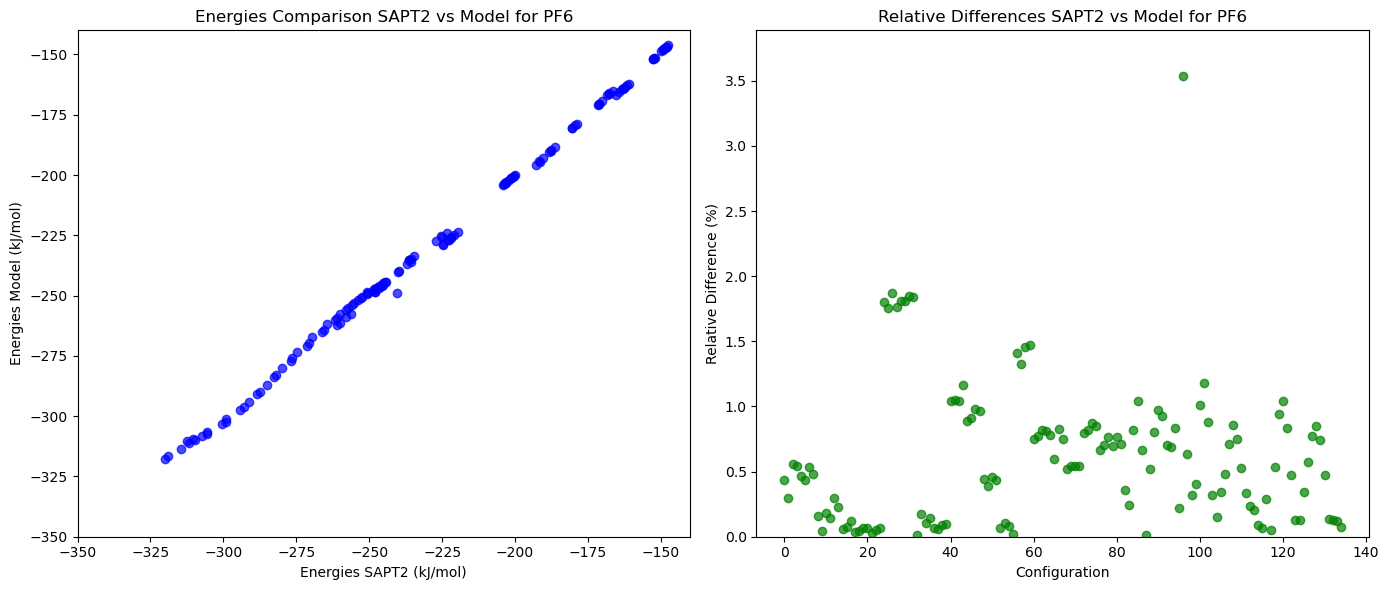

In [283]:
energies_sapt2_pf6 = np.array(pf6_chn_total_energy)  # Lista de energías SAPT2 en kJ/mol
pf6_total_energy_predicted = np.array([ dimer.total_energy() for dimer in pf6_chn_dimer_set])  # Lista de energías predichas en kJ/mol

# Calcular las diferencias relativas
relative_diffs = np.abs((pf6_total_energy_predicted - energies_sapt2_pf6) / energies_sapt2_pf6) * 100

# Crear el gráfico de dispersión
plt.figure(figsize=(14, 6))

# Gráfico de dispersión de las energías
plt.subplot(1, 2, 1)
plt.scatter(energies_sapt2_pf6, pf6_total_energy_predicted, color='blue', alpha=0.7)
plt.title('Energies Comparison SAPT2 vs Model for PF6')
plt.xlabel('Energies SAPT2 (kJ/mol)')
plt.ylabel('Energies Model (kJ/mol)')
plt.xlim(-350, -140)  # Establecer límites en el eje x
plt.ylim(-350, -140) # Establecer límites en el eje y

# Gráfico de dispersión de las diferencias relativas
plt.subplot(1, 2, 2)
plt.scatter(range(len(relative_diffs)), relative_diffs, color='green', alpha=0.7)
plt.title('Relative Differences SAPT2 vs Model for PF6')
plt.xlabel('Configuration')
plt.ylabel('Relative Difference (%)')
plt.ylim(0, max(relative_diffs) * 1.1)  # Establecer límites en el eje y

# Mostrar el gráfico
plt.tight_layout()
plt.show()

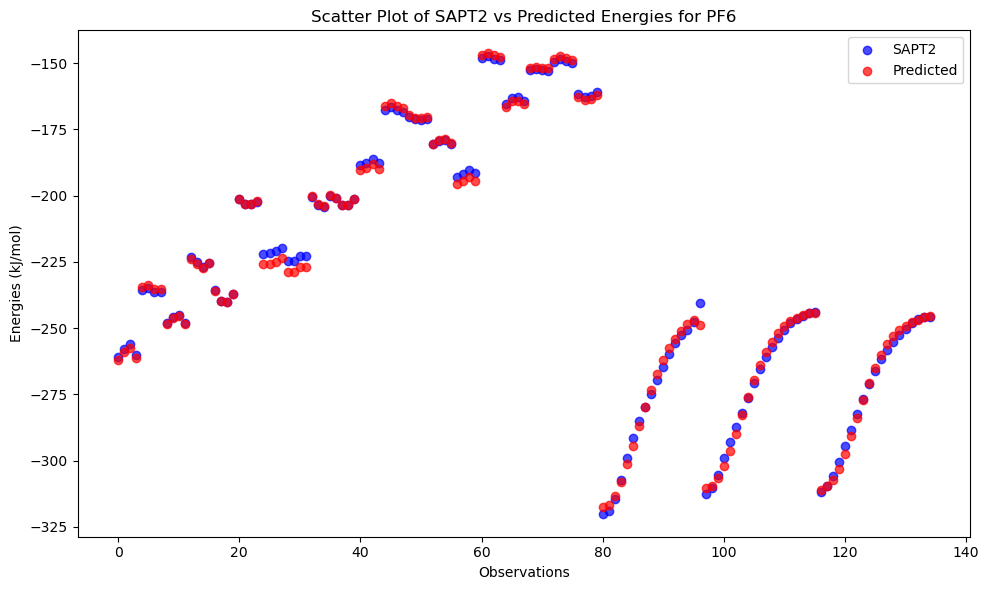

In [284]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))

# Graficar las energías SAPT2 (en azul)
plt.scatter(range(len(energies_sapt2_pf6)), energies_sapt2_pf6, color='blue', label='SAPT2', alpha=0.7)

# Graficar las energías predichas (en rojo)
plt.scatter(range(len(pf6_total_energy_predicted)), pf6_total_energy_predicted, color='red', label='Predicted', alpha=0.7)

# Añadir detalles al gráfico
plt.title('Scatter Plot of SAPT2 vs Predicted Energies for PF6')
plt.xlabel('Observations')
plt.ylabel('Energies (kJ/mol)')
plt.legend()  # Mostrar la leyenda con etiquetas de color

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [287]:
instance = 96 # 97 and 98 outliers # now 96 is weird
pf6_chn_dimer_set[instance].visual()
print(f'SAPT2 energy: {pf6_chn_total_energy[instance]}')
relative_diff = abs((pf6_chn_total_energy[instance] - pf6_chn_dimer_set[instance].total_energy())/pf6_chn_total_energy[instance])*100
print(f'relative difference: {relative_diff} % ')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

calculated energy: -248.9655589260691 
SAPT2 energy: -240.46727788167243
relative difference: 3.534069632783235 % 


In [315]:
#################################
#################################
#### Optimization pf6_chn #######
#################################
################################

In [262]:
pf6_chn_dimer_set[0].dimer_order_types ## order for the vector

['F', 'P', 'C(4)', 'H(4)', 'H(1)', 'N(3)']

In [263]:
pf6_chn_dimer_set[0].dimer_buckingham_params

{'F': {'A': 13044.8082, 'B': 2406.77297, 'C': 1.69854449},
 'P': {'A': 8781.04056, 'B': 630.760768, 'C': 1.51810656},
 'C(4)': {'A': 978.36, 'B': 131571, 'C': 3.6},
 'H(4)': {'A': 0.0, 'B': 764.9, 'C': 3.56},
 'H(1)': {'A': 278.37, 'B': 12680, 'C': 3.56},
 'N(3)': {'A': 2376.55, 'B': 191935, 'C': 3.48}}

In [264]:
original_buckingham_parameters_vector = []

for type in pf6_chn_dimer_set[0].dimer_order_types:
    original_buckingham_parameters_vector.append(pf6_chn_dimer_set[0].dimer_buckingham_params[type]['A'])

for type in pf6_chn_dimer_set[0].dimer_order_types:
    original_buckingham_parameters_vector.append(pf6_chn_dimer_set[0].dimer_buckingham_params[type]['B'])
    
for type in pf6_chn_dimer_set[0].dimer_order_types:
    original_buckingham_parameters_vector.append(pf6_chn_dimer_set[0].dimer_buckingham_params[type]['C'])

original_buckingham_parameters_vector

[13044.8082,
 8781.04056,
 978.36,
 0.0,
 278.37,
 2376.55,
 2406.77297,
 630.760768,
 131571,
 764.9,
 12680,
 191935,
 1.69854449,
 1.51810656,
 3.6,
 3.56,
 3.56,
 3.48]

In [265]:
pf6_chn_optimize = EnergyOptimize(pf6_chn_dimer_set, pf6_chn_total_energy)

# Definir el punto inicial para la optimización
x0 = np.array(original_buckingham_parameters_vector)

# Realizar la minimización usando el método Nelder-Mead
result = minimize(pf6_chn_optimize.dimer_set_optimize_total, x0, method='Nelder-Mead')

# Imprimir el resultado
print("Punto óptimo:", result.x)
print("Valor de la función en el punto óptimo:", result.fun)
print("Información completa del resultado:\n", result)


C:\Users\migue\AppData\Local\Temp\ipykernel_28312\3401249212.py:61: RuntimeWarning: invalid value encountered in sqrt
  v_12a = (np.outer(np.array(vector_mol1_a), np.array(vector_mol2_a)).flatten())**(0.5)


Punto óptimo: [1.25245814e+04 8.50092649e+03 9.76618460e+02 2.25451832e-05
 2.70782383e+02 2.28816383e+03 2.64658600e+03 5.98129383e+02
 1.39355231e+05 6.89049508e+02 1.39479857e+04 1.73899497e+05
 1.76967562e+00 1.48749717e+00 3.77124887e+00 3.71869158e+00
 3.60050263e+00 3.46063789e+00]
Valor de la función en el punto óptimo: 458.44432166055594
Información completa del resultado:
        message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 458.44432166055594
             x: [ 1.252e+04  8.501e+03 ...  3.601e+00  3.461e+00]
           nit: 2605
          nfev: 3600
 final_simplex: (array([[ 1.252e+04,  8.501e+03, ...,  3.601e+00,
                         3.461e+00],
                       [ 1.253e+04,  8.502e+03, ...,  3.600e+00,
                         3.460e+00],
                       ...,
                       [ 1.253e+04,  8.506e+03, ...,  3.600e+00,
                         3.460e+00],
                      

## PF6-PF6

In [178]:
pf6_to_pf6_origin_file = r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_chn_sphere\PF6_centered.xyz'
pf6_pf6_1_energies = np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_pf6\pf6_pf6_1_energies.npy')
pf6_pf6_1_induction_energies = np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_pf6\pf6_pf6_1_induction_energies.npy')
pf6_pf6_1_configurations = np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_pf6\pf6_pf6_1_configurations.npy')

#### First batch pf6, to get initial values for a b c 

In [179]:
pf6_to_pf6_origin = MolBuckingham(pf6_to_pf6_origin_file, pf6_charges)

pf6_pf6_1_dimer_set = []

for coordinates in pf6_pf6_1_configurations : 
    molecule =  pf6_to_pf6_origin.copy([0,0,0])
    molecule.coordinates = coordinates
    dimer = Dimer(pf6_to_pf6_origin, molecule)
    pf6_pf6_1_dimer_set.append(dimer)


{'F', 'P'}
['F', 'P']


In [181]:
observation = 15

pf6_pf6_1_dimer_set[observation].visual() # el 4 es el bueno este que se ve es el 3 y se pega.
print(f'sapt2 energy is: {pf6_pf6_1_energies[observation]}')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

calculated energy: 250.49676333325294 
sapt2 energy is: 252.284295


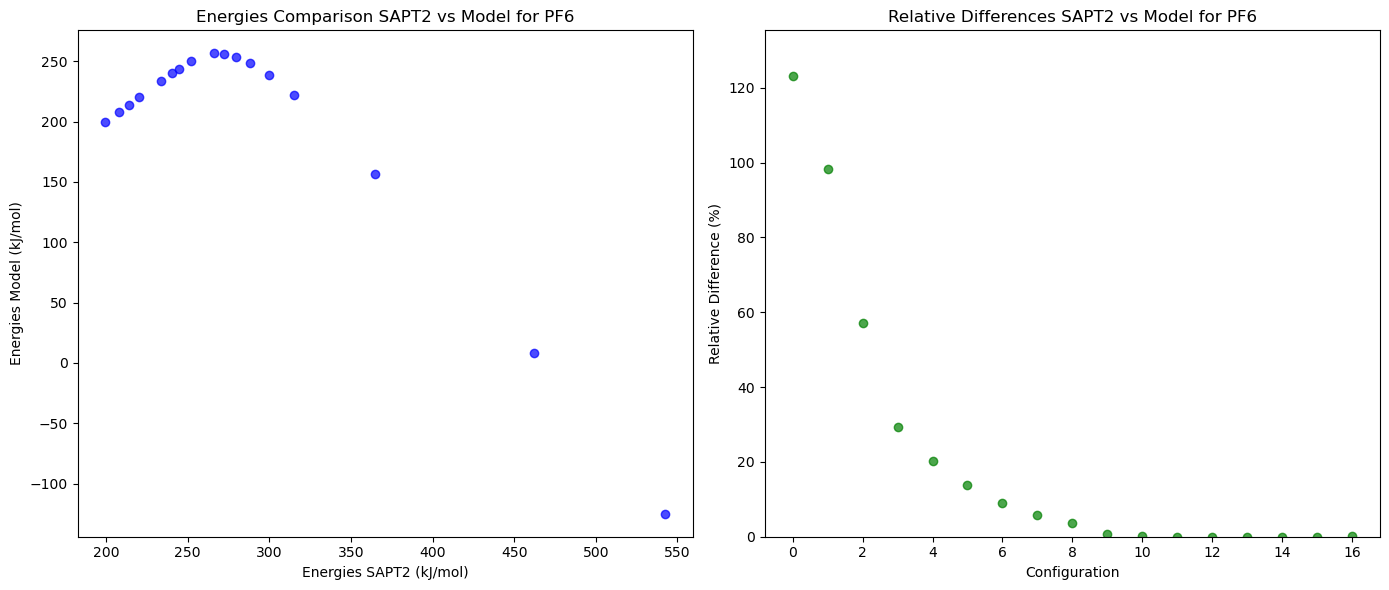

In [126]:
energies_sapt2_pf6_pf6 = np.array(pf6_pf6_1_energies[6:])  # Lista de energías SAPT2 en kJ/mol
pf6_pf6_total_energy_predicted = np.array([ dimer.total_energy() for dimer in pf6_pf6_1_dimer_set[6:]])  # Lista de energías predichas en kJ/mol

# Calcular las diferencias relativas
relative_diffs = np.abs((pf6_pf6_total_energy_predicted - energies_sapt2_pf6_pf6) / energies_sapt2_pf6_pf6) * 100

# Crear el gráfico de dispersión
plt.figure(figsize=(14, 6))

# Gráfico de dispersión de las energías
plt.subplot(1, 2, 1)
plt.scatter(energies_sapt2_pf6_pf6, pf6_pf6_total_energy_predicted, color='blue', alpha=0.7)
plt.title('Energies Comparison SAPT2 vs Model for PF6')
plt.xlabel('Energies SAPT2 (kJ/mol)')
plt.ylabel('Energies Model (kJ/mol)')
# plt.xlim(-350, -140)  # Establecer límites en el eje x
# plt.ylim(-350, -140) # Establecer límites en el eje y

# Gráfico de dispersión de las diferencias relativas
plt.subplot(1, 2, 2)
plt.scatter(range(len(relative_diffs)), relative_diffs, color='green', alpha=0.7)
plt.title('Relative Differences SAPT2 vs Model for PF6')
plt.xlabel('Configuration')
plt.ylabel('Relative Difference (%)')
plt.ylim(0, max(relative_diffs) * 1.1)  # Establecer límites en el eje y

# Mostrar el gráfico
plt.tight_layout()
plt.show()

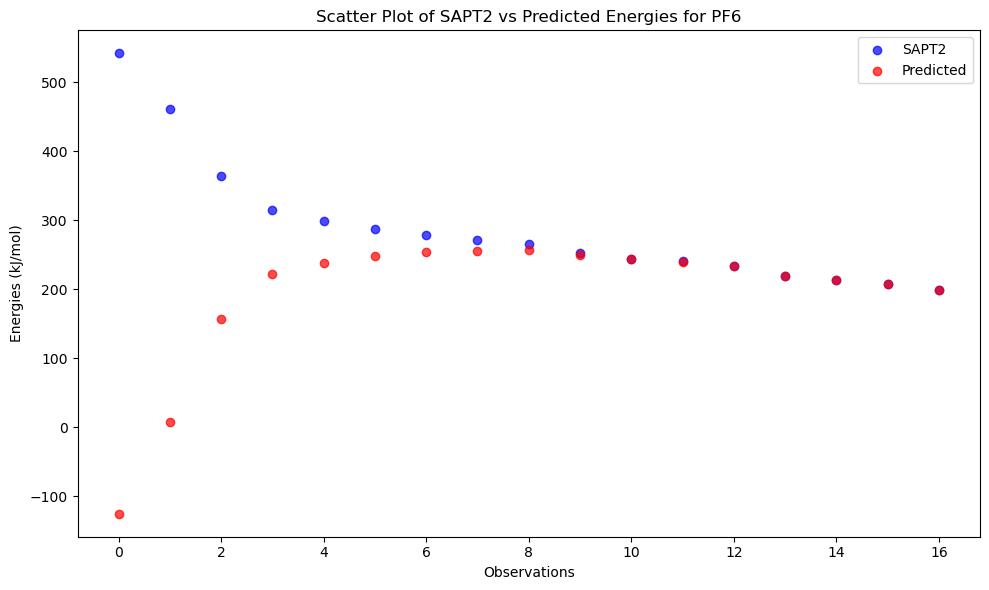

In [182]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))

# Graficar las energías SAPT2 (en azul)
plt.scatter(range(len(energies_sapt2_pf6_pf6)), energies_sapt2_pf6_pf6, color='blue', label='SAPT2', alpha=0.7)

# Graficar las energías predichas (en rojo)
plt.scatter(range(len(pf6_pf6_total_energy_predicted)), pf6_pf6_total_energy_predicted, color='red', label='Predicted', alpha=0.7)

# Añadir detalles al gráfico
plt.title('Scatter Plot of SAPT2 vs Predicted Energies for PF6')
plt.xlabel('Observations')
plt.ylabel('Energies (kJ/mol)')
plt.legend()  # Mostrar la leyenda con etiquetas de color

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
###########################
###########################
###  Done for dispersion ##
###########################
###########################

In [78]:
pf6_pf6_1_optimize = EnergyOptimize(pf6_pf6_1_dimer_set[6:], pf6_pf6_1_energies[6:], pf6_pf6_1_induction_energies[6:])

In [ ]:
# alston values:     cpp = 30.61343 hartree*bohr**6 --> cpp * bohr_6_to_angstrom_6 * hartree_to_kJ/mol 
#                    cff = 11.50171 hartree*bohr**6 --> cpp * bohr_6_to_angstrom_6 * hartree_to_kJ/mol

In [79]:
f_a = 11.50171 * hartree_to_kJ * bohr_6_to_angstrom_6 
p_a = 30.61343 * hartree_to_kJ * bohr_6_to_angstrom_6 

print(f_a,p_a)

663.1000848903531 1764.9347820267492


In [81]:
# Definir el punto inicial para la optimización
x0 = np.array([f_a, p_a])

# Realizar la minimización usando el método Nelder-Mead
result = minimize(pf6_pf6_1_optimize.dimer_set_optimize_disp, x0, method='Nelder-Mead')

# Imprimir el resultado
print("Punto óptimo:", result.x)
print("Valor de la función en el punto óptimo:", result.fun)
print("Información completa del resultado:\n", result)

Punto óptimo: [   506.49770534 106499.93830613]
Valor de la función en el punto óptimo: 11.98645858702579
Información completa del resultado:
        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 11.98645858702579
             x: [ 5.065e+02  1.065e+05]
           nit: 105
          nfev: 205
 final_simplex: (array([[ 5.065e+02,  1.065e+05],
                       [ 5.065e+02,  1.065e+05],
                       [ 5.065e+02,  1.065e+05]]), array([ 1.199e+01,  1.199e+01,  1.199e+01]))


In [ ]:
##########################
# #######################
# Finish dispersion #####
## Optimization##########
#########################

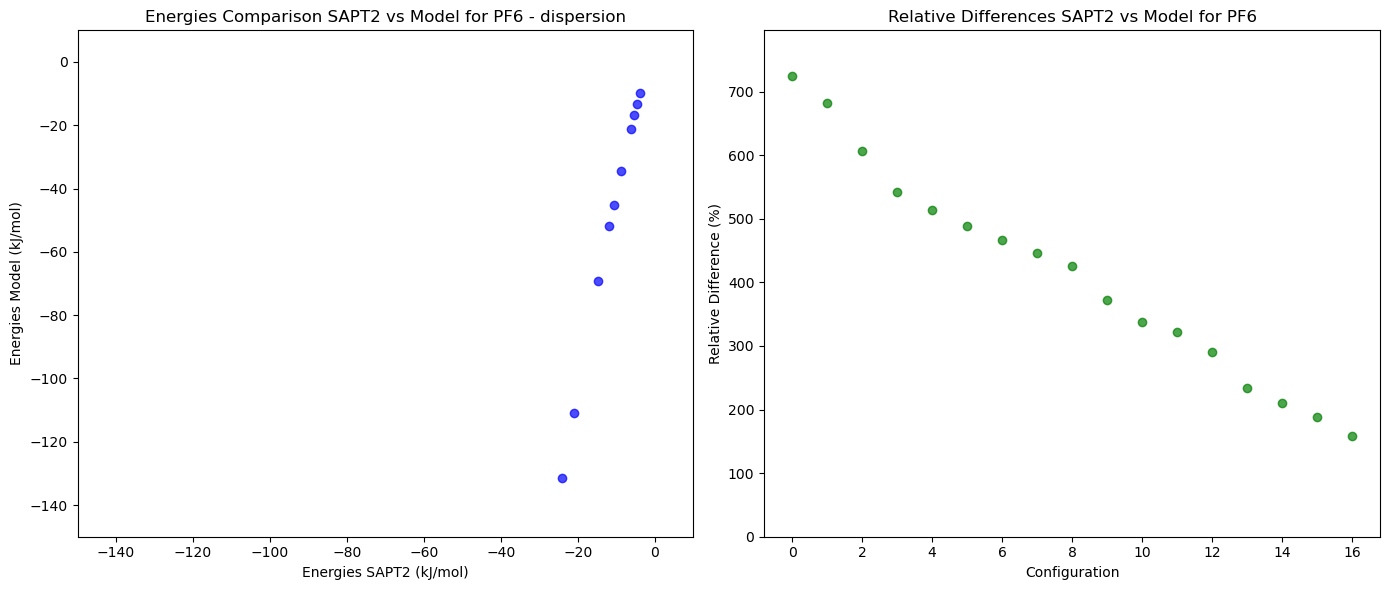

In [128]:
energies_sapt2_pf6_pf6_disp = np.array(pf6_pf6_1_induction_energies[6:])  # Lista de energías SAPT2 en kJ/mol
pf6_pf6_disp_energy_predicted = np.array([ dimer.disp_energy() for dimer in pf6_pf6_1_dimer_set[6:]])  # Lista de energías predichas en kJ/mol

# Calcular las diferencias relativas
relative_diffs = np.abs((pf6_pf6_disp_energy_predicted - energies_sapt2_pf6_pf6_disp) / energies_sapt2_pf6_pf6_disp) * 100

# Crear el gráfico de dispersión
plt.figure(figsize=(14, 6))

# Gráfico de dispersión de las energías
plt.subplot(1, 2, 1)
plt.scatter(energies_sapt2_pf6_pf6_disp, pf6_pf6_disp_energy_predicted, color='blue', alpha=0.7)
plt.title('Energies Comparison SAPT2 vs Model for PF6 - dispersion')
plt.xlabel('Energies SAPT2 (kJ/mol)')
plt.ylabel('Energies Model (kJ/mol)')
plt.xlim(-150, 10)  # Establecer límites en el eje x
plt.ylim(-150, 10) # Establecer límites en el eje y

# Gráfico de dispersión de las diferencias relativas
plt.subplot(1, 2, 2)
plt.scatter(range(len(relative_diffs)), relative_diffs, color='green', alpha=0.7)
plt.title('Relative Differences SAPT2 vs Model for PF6')
plt.xlabel('Configuration')
plt.ylabel('Relative Difference (%)')
plt.ylim(0, max(relative_diffs) * 1.1)  # Establecer límites en el eje y

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [129]:
pf6_pf6_1_dimer_set[21].disp_energy()

-13.393638585601021

In [130]:
pf6_pf6_1_induction_energies[21]

-4.6492894185599996

In [ ]:
###########################
##### exp part optimi #####
###########################

In [49]:
pf6_pf6_1_exp_energy = pf6_pf6_1_energies - pf6_pf6_1_induction_energies - np.array([dimer.elst_energy() for dimer in pf6_pf6_1_dimer_set ])

In [50]:
pf6_pf6_1_optimize = EnergyOptimize(pf6_pf6_1_dimer_set[6:], pf6_pf6_1_energies[6:], pf6_pf6_1_induction_energies[6:], pf6_pf6_1_exp_energy[6:])

In [51]:
# no initial vector??? , no data 
# (F_b, P_b , F_c, P_c)
x0 = np.array([190000,190000,3.48,3.48])

# Realizar la minimización usando el método Nelder-Mead
result = minimize(pf6_pf6_1_optimize.dimer_set_optimize_exp,x0, method='Nelder-Mead')

# Imprimir el resultado
print("Punto óptimo:", result.x)
print("Valor de la función en el punto óptimo:", result.fun)
print("Información completa del resultado:\n", result)

Punto óptimo: [2.61185461e+05 5.06009571e+05 4.06570526e+00 4.08254308e+00]
Valor de la función en el punto óptimo: 48.448205654132785
Información completa del resultado:
        message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 48.448205654132785
             x: [ 2.612e+05  5.060e+05  4.066e+00  4.083e+00]
           nit: 483
          nfev: 800
 final_simplex: (array([[ 2.612e+05,  5.060e+05,  4.066e+00,  4.083e+00],
                       [ 2.612e+05,  5.004e+05,  4.066e+00,  4.080e+00],
                       ...,
                       [ 2.612e+05,  5.075e+05,  4.066e+00,  4.076e+00],
                       [ 2.611e+05,  5.171e+05,  4.066e+00,  4.074e+00]]), array([ 4.845e+01,  4.845e+01,  4.845e+01,  4.845e+01,
                        4.845e+01]))


In [ ]:
###########################
#####  Finish      ########
##### exp part optimi #####
###########################

## second batch pf6-pf6

In [172]:
pf6_pf6_2_configurations = np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_pf6\pf6_pf6_2_configurations.npy')
pf6_pf6_2_energies= np.load(r'C:\Users\migue\OneDrive\Desktop\QM_Project\for_molecules\pf6_pf6\pf6_pf6_2_energies.npy')

In [173]:
pf6_to_pf6_origin = MolBuckingham(pf6_to_pf6_origin_file, pf6_charges)

pf6_pf6_2_dimer_set = []

for coordinates in pf6_pf6_2_configurations : 
    molecule =  pf6_to_pf6_origin.copy([0,0,0])
    molecule.coordinates = coordinates
    dimer = Dimer(pf6_to_pf6_origin, molecule)
    pf6_pf6_2_dimer_set.append(dimer)

{'F', 'P'}
['F', 'P']


In [175]:
observation = 18 # from 18 is a good option

pf6_pf6_2_dimer_set[observation].visual() # el 4 es el bueno este que se ve es el 3 y se pega.
print(f'sapt2 energy is: {pf6_pf6_2_energies[observation]}')

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

calculated energy: 250.58955191240688 
sapt2 energy is: 249.86354288


In [169]:
pf6_pf6_2_optimize = EnergyOptimize(pf6_pf6_1_dimer_set[18:], pf6_pf6_1_energies[18:])

In [ ]:
        # 'F': {'A': 2.5*663.1000848903531, 'B': 236361.448, 'C': 4.01416701},
        # 'P': {'A': 2.5*1764.9347820267492, 'B': 252780.774, 'C': 4.09048675}

In [170]:
# no initial vector??? , no data 
# (F_b, P_b , F_c, P_c)
x0 = np.array([2.5*663.1000848903531,2.5*1764.9347820267492,
               236361.448,252780.774,4.01416701,4.09048675])

# Realizar la minimización usando el método Nelder-Mead
result = minimize(pf6_pf6_2_optimize.dimer_set_optimize_total, x0, method='Nelder-Mead')

# Imprimir el resultado
print("Punto óptimo:", result.x)
print("Valor de la función en el punto óptimo:", result.fun)
print("Información completa del resultado:\n", result)

C:\Users\migue\AppData\Local\Temp\ipykernel_28312\2644120888.py:62: RuntimeWarning: invalid value encountered in sqrt
  v_12b = (np.outer(np.array(vector_mol1_b), np.array(vector_mol2_b)).flatten())**(0.5)


Punto óptimo: [1.30448082e+04 8.78104056e+03 2.40677297e+03 6.30760768e+02
 1.69854449e+00 1.51810656e+00]
Valor de la función en el punto óptimo: 0.04452807660270566
Información completa del resultado:
        message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 0.04452807660270566
             x: [ 1.304e+04  8.781e+03  2.407e+03  6.308e+02  1.699e+00
                  1.518e+00]
           nit: 778
          nfev: 1200
 final_simplex: (array([[ 1.304e+04,  8.781e+03, ...,  1.699e+00,
                         1.518e+00],
                       [ 1.305e+04,  8.781e+03, ...,  1.699e+00,
                         1.518e+00],
                       ...,
                       [ 1.304e+04,  8.781e+03, ...,  1.699e+00,
                         1.518e+00],
                       [ 1.304e+04,  8.781e+03, ...,  1.699e+00,
                         1.518e+00]]), array([ 4.453e-02,  4.453e-02,  4.454e-02,  4.454e-02,
          

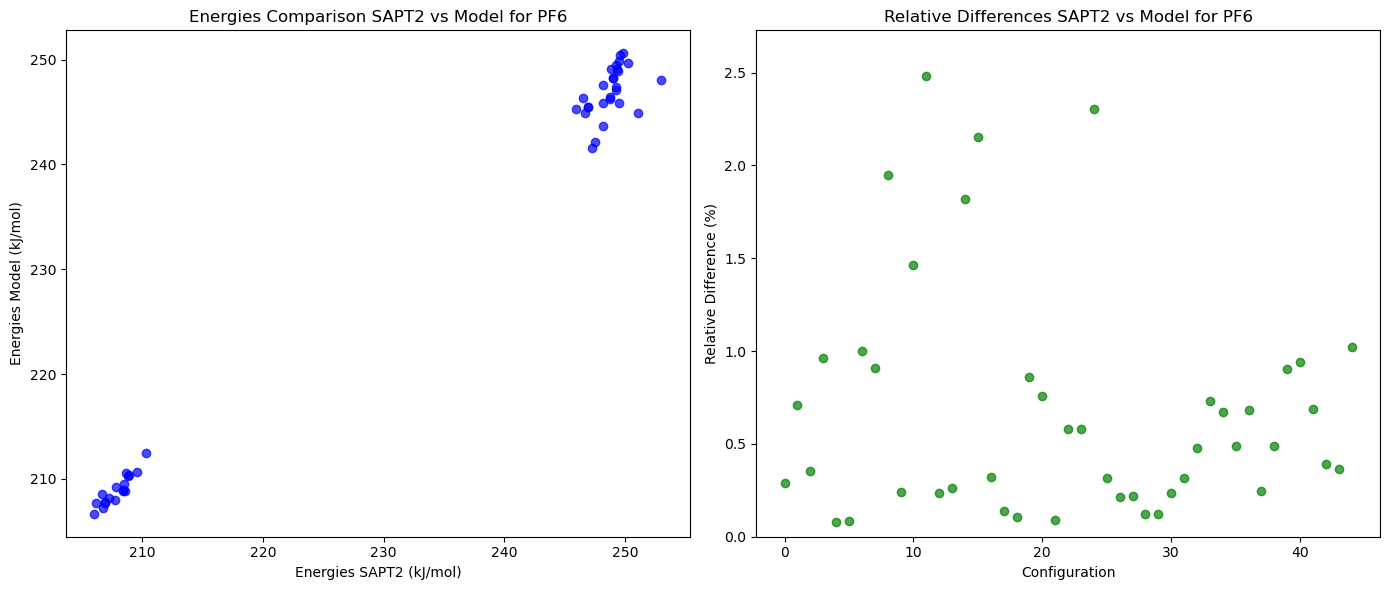

In [176]:
energies_sapt2_pf6_pf6_2 = np.array(pf6_pf6_2_energies[18:])  # Lista de energías SAPT2 en kJ/mol
pf6_pf6_total_energy_predicted_2 = np.array([ dimer.total_energy() for dimer in pf6_pf6_2_dimer_set[18:]])  # Lista de energías predichas en kJ/mol

# Calcular las diferencias relativas
relative_diffs = np.abs((pf6_pf6_total_energy_predicted_2 - energies_sapt2_pf6_pf6_2) / energies_sapt2_pf6_pf6_2) * 100

# Crear el gráfico de dispersión
plt.figure(figsize=(14, 6))

# Gráfico de dispersión de las energías
plt.subplot(1, 2, 1)
plt.scatter(energies_sapt2_pf6_pf6_2, pf6_pf6_total_energy_predicted_2, color='blue', alpha=0.7)
plt.title('Energies Comparison SAPT2 vs Model for PF6')
plt.xlabel('Energies SAPT2 (kJ/mol)')
plt.ylabel('Energies Model (kJ/mol)')
# plt.xlim(-350, -140)  # Establecer límites en el eje x
# plt.ylim(-350, -140) # Establecer límites en el eje y

# Gráfico de dispersión de las diferencias relativas
plt.subplot(1, 2, 2)
plt.scatter(range(len(relative_diffs)), relative_diffs, color='green', alpha=0.7)
plt.title('Relative Differences SAPT2 vs Model for PF6')
plt.xlabel('Configuration')
plt.ylabel('Relative Difference (%)')
plt.ylim(0, max(relative_diffs) * 1.1)  # Establecer límites en el eje y

# Mostrar el gráfico
plt.tight_layout()
plt.show()

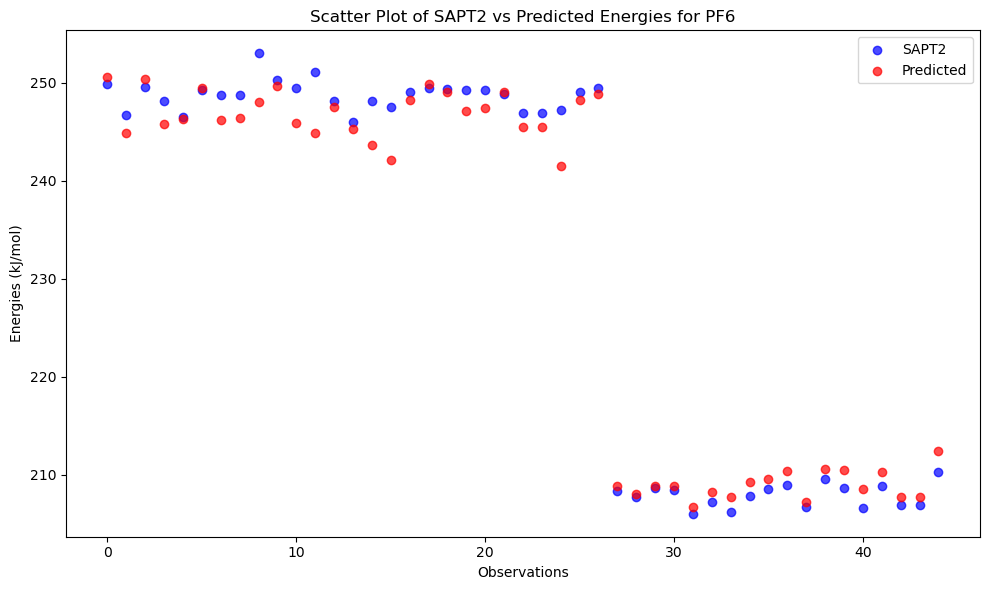

In [177]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))

# Graficar las energías SAPT2 (en azul)
plt.scatter(range(len(energies_sapt2_pf6_pf6_2)), energies_sapt2_pf6_pf6_2, color='blue', label='SAPT2', alpha=0.7)

# Graficar las energías predichas (en rojo)
plt.scatter(range(len(pf6_pf6_total_energy_predicted_2)), pf6_pf6_total_energy_predicted_2, color='red', label='Predicted', alpha=0.7)

# Añadir detalles al gráfico
plt.title('Scatter Plot of SAPT2 vs Predicted Energies for PF6')
plt.xlabel('Observations')
plt.ylabel('Energies (kJ/mol)')
plt.legend()  # Mostrar la leyenda con etiquetas de color

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
#######################################################################################
#######################################################################################
#######################################################################################

| Data                      | Units      | Converted to  | How          |
|-----------                |----------- |-----------    |-----------   |
|C6 coefficients PF6 (A)    | ht*bohr**6 |       kJ/mol*angstrom**6        |    2625.5*0.0219586          |
|Charges [PF6 and Quin]     |     e      |               |              |
|Williams parameters (A,B,C)|   kJ/mol   |  -- (same)              |  --            |
|Psi4 energy                |    hartree default    |    kJ/mol           |   * 2625.5           |
|xyz file length            | Angstroms  |   -- same            |   --           |
|pdb file coordinates len   | Angstroms  |               |              |
|psi4 expected - [in code]  | Angstroms  | nm for openmm |writed in code|
|OpenMM expected units      |nm,kJ,mol,Da|     -         |              |
|OpenMM expected units pdb  | Angstrom   |               |              |
